## Creation of Environment with the step Function

State: (4, 9)
Next state, reward & done value are: 
(4, 4) 0 False
--------------------Lets play game--------------
Player's cards: [(9, 'black')], Total: 9
Do you want to 'hit' or 'stick'? hiy
Invalid action. Please enter 'hit' or 'stick'.
Player's cards: [(9, 'black')], Total: 9
Do you want to 'hit' or 'stick'? stick
Player's final cards: [(9, 'black')], Total: 9
Dealer's final cards: [(5, 'black'), (3, 'black'), (9, 'black')], Total: 17
Player loses!


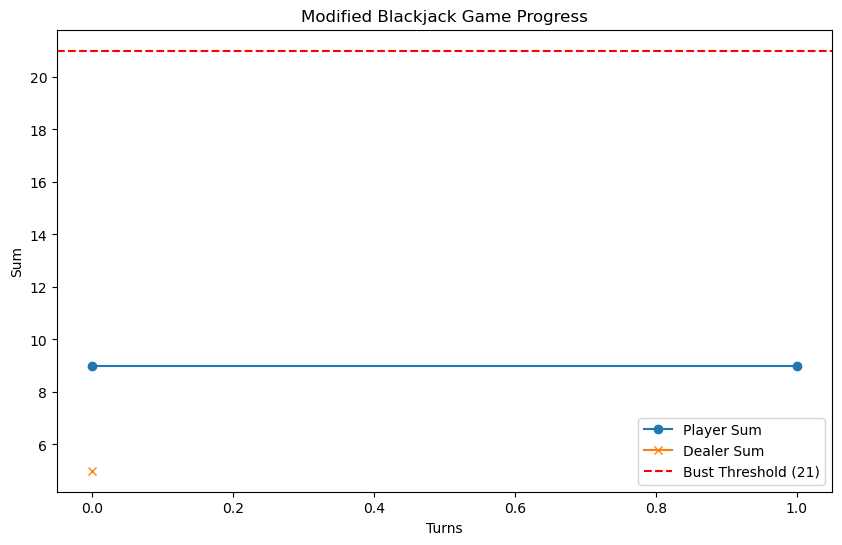

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class ModifiedBlackjack:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.player_sum = np.random.randint(1, 14)
        self.dealer_card = np.random.randint(1, 14)
        self.player_cards = [(self.player_sum, 'black')]
        self.dealer_cards = [(self.dealer_card, 'black')]
        return (self.dealer_card, self.player_sum)
    
    def step(self, state, action):
        dealer_card, player_sum = state
        
        if action == 'hit':
            card_value = np.random.randint(1, 14)
            card_color = 'black' if np.random.rand() < 2/3 else 'red'
            self.player_cards.append((card_value, card_color))
            
            if card_color == 'black':
                player_sum += card_value
            else:
                player_sum -= card_value
                
            if player_sum > 21 or player_sum < 1:
                return (dealer_card, player_sum), -1, True
            else:
                return (dealer_card, player_sum), 0, False
        elif action == 'stick':
            while dealer_card < 17:
                card_value = np.random.randint(1, 14)
                card_color = 'black' if np.random.rand() < 2/3 else 'red'
                self.dealer_cards.append((card_value, card_color))
                
                if card_color == 'black':
                    dealer_card += card_value
                else:
                    dealer_card -= card_value
                    
                if dealer_card > 21 or dealer_card < 1:
                    return (dealer_card, player_sum), 1, True
            
            if player_sum > dealer_card:
                return (dealer_card, player_sum), 1, True
            elif player_sum < dealer_card:
                return (dealer_card, player_sum), -1, True
            else:
                return (dealer_card, player_sum), 0, True

    def play_game(self):
        state = self.reset()
        done = False
        player_sums = [state[1]]
        dealer_sums = [state[0]]

        # Player's turn
        while not done:
            print(f"Player's cards: {self.player_cards}, Total: {state[1]}")
            action = input("Do you want to 'hit' or 'stick'? ")
            if action == 'hit' or action == 'stick':
                state, reward, done = self.step(state, action)
                player_sums.append(state[1])
            else:
                print("Invalid action. Please enter 'hit' or 'stick'.")
            if action == 'stick':
                break

        # Dealer's turn, only if player sticks and doesn't go bust
        if not done:
            state, reward, done = self.step(state, 'stick')
            dealer_sums = [self.dealer_cards[0][0]] + [card[0] if card[1] == 'black' else -card[0] for card in self.dealer_cards[1:]]

        # Print final result
        print(f"Player's final cards: {self.player_cards}, Total: {state[1]}")
        print(f"Dealer's final cards: {self.dealer_cards}, Total: {state[0]}")
        if reward == 1:
            print("Player wins!")
        elif reward == -1:
            print("Player loses!")
        else:
            print("It's a draw!")
        
        # Plot the game progress
        plt.figure(figsize=(10, 6))
        plt.plot(player_sums, label='Player Sum', marker='o')
        plt.plot(dealer_sums, label='Dealer Sum', marker='x')
        plt.axhline(y=21, color='r', linestyle='--', label='Bust Threshold (21)')
        plt.xlabel('Turns')
        plt.ylabel('Sum')
        plt.title('Modified Blackjack Game Progress')
        plt.legend()
        plt.show()


env = ModifiedBlackjack()
state = env.reset()
print("State:",state)
next_state, reward, done = env.step(state, 'hit')
print("Next state, reward & done value are: ")
print(next_state, reward, done)

print("--------------------Lets play game--------------")
env.play_game()


### Monte Carlo Control Implementation

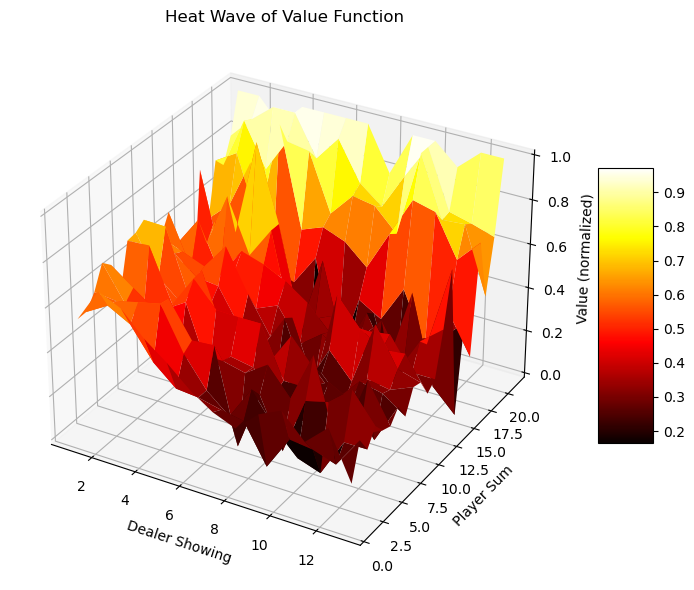

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class cardGame_MonteCarlo:
    def __init__(self, env, n0=100):
        self.env = env
        self.n0 = n0
        self.Q = {}
        self.returns = {}
        self.N = {}
    
    def get_action(self, state):
        if state not in self.N:
            self.N[state] = 0
        epsilon = self.n0 / (self.n0 + self.N[state])
        if np.random.rand() < epsilon:
            return np.random.choice(['hit', 'stick'])
        else:
            if state not in self.Q or np.random.rand() < 0.5:
                return 'hit'
            else:
                return 'stick'
    
    def update(self, state, action, reward):
        if state not in self.Q:
            self.Q[state] = {'hit': 0, 'stick': 0}
            self.returns[state] = {'hit': [], 'stick': []}
        
        self.returns[state][action].append(reward)
        self.Q[state][action] = np.mean(self.returns[state][action])
        self.N[state] += 1
    
    def run(self, episodes):
        for episode in range(episodes):
            state = self.env.reset()
            states_actions_rewards = []
            done = False
            
            while not done:
                action = self.get_action(state)
                next_state, reward, done = self.env.step(state, action)
                states_actions_rewards.append((state, action, reward))
                state = next_state
            
            for state, action, reward in states_actions_rewards:
                self.update(state, action, reward)
    
    def plot_value_function(self):
        fig = plt.figure(figsize=(8, 6))

        # Heat Wave (3D Surface Plot)
        ax = fig.add_subplot(111, projection='3d')

        dealer_cards = np.arange(1, 14)
        player_sums = np.arange(1, 22)
        value_function = np.zeros((len(dealer_cards), len(player_sums)))

        min_value = float('inf')
        max_value = float('-inf')

        for state in self.Q:
            dealer_card, player_sum = state
            value = max(self.Q[state]['hit'], self.Q[state]['stick'])
            min_value = min(min_value, value)
            max_value = max(max_value, value)

        for state in self.Q:
            dealer_card, player_sum = state
            value = max(self.Q[state]['hit'], self.Q[state]['stick'])
            normalized_value = (value - min_value) / (max_value - min_value)  # Normalize between 0 and 1
            value_function[dealer_card-1, player_sum-1] = normalized_value

        X, Y = np.meshgrid(dealer_cards, player_sums)
        Z = value_function.T  # Transpose to match the correct orientation
        
        surf = ax.plot_surface(X, Y, Z, cmap='hot', edgecolor='none')
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value (normalized)')
        ax.set_title('Heat Wave of Value Function')

        plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        plt.tight_layout()
        plt.show()

# Example of how to use this class, assuming 'env' is your game environment object
mc_control = cardGame_MonteCarlo(env)
mc_control.run(10000)
mc_control.plot_value_function()


### Sarsa(λ) Implementation

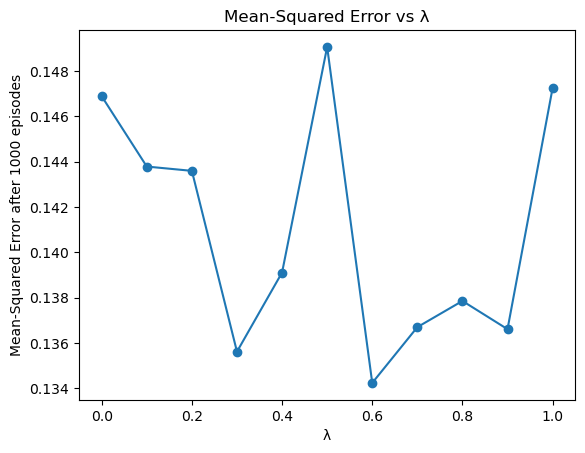

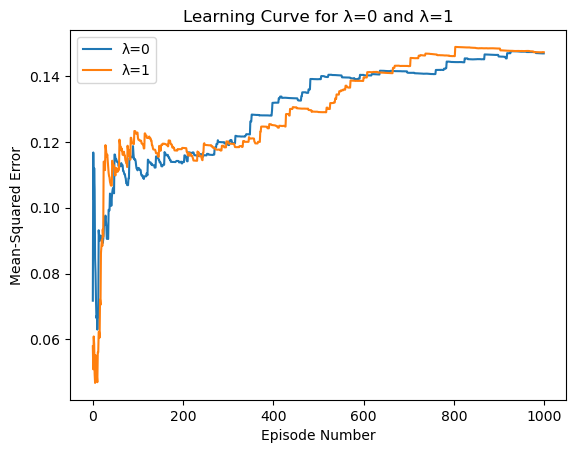

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class cardGame_SarsaLambda:
    def __init__(self, env, lambdas, n0=100):
        self.env = env
        self.lambdas = lambdas
        self.n0 = n0
        self.Q = {l: {} for l in lambdas}
        self.N = {}
    
    def get_action(self, state, l):
        if state not in self.N:
            self.N[state] = 0
        epsilon = self.n0 / (self.n0 + self.N[state])
        if np.random.rand() < epsilon:
            return np.random.choice(['hit', 'stick'])
        else:
            if state not in self.Q[l] or np.random.rand() < 0.5:
                return 'hit'
            else:
                return 'stick'
    
    def run(self, episodes, mc_control):
        mean_square_error = {l: [] for l in self.lambdas}
        
        for episode in range(episodes):
            for l in self.lambdas:
                state = self.env.reset()
                action = self.get_action(state, l)
                done = False
                E = {}
                
                while not done:
                    next_state, reward, done = self.env.step(state, action)
                    next_action = self.get_action(next_state, l) if not done else None
                    
                    if state not in self.Q[l]:
                        self.Q[l][state] = {'hit': 0, 'stick': 0}
                    if next_state not in self.Q[l]:
                        self.Q[l][next_state] = {'hit': 0, 'stick': 0}
                    
                    delta = reward + (self.Q[l][next_state][next_action] if next_action else 0) - self.Q[l][state][action]
                    E[(state, action)] = E.get((state, action), 0) + 1
                    
                    for s, a in E:
                        self.Q[l][s][a] += (1 / self.n0) * delta * E[(s, a)]
                        E[(s, a)] *= l
                    
                    state, action = next_state, next_action
                
                true_Q = mc_control.Q
                error_sum = 0
                count = 0
                for s in self.Q[l]:
                    for a in self.Q[l][s]:
                        if s in true_Q and a in true_Q[s]:
                            error_sum += (self.Q[l][s][a] - true_Q[s][a]) ** 2
                            count += 1
                mean_square_error[l].append(error_sum / count if count > 0 else 0)
        
        return mean_square_error



lambdas = np.arange(0, 1.1, 0.1)  
sarsa_lambda = cardGame_SarsaLambda(env, lambdas)
mean_square_error = sarsa_lambda.run(1000, mc_control)

# Plotting the mean-squared error against λ
mse_at_1000_episodes = [mean_square_error[l][-1] for l in lambdas]
plt.plot(lambdas, mse_at_1000_episodes, marker='o')
plt.xlabel('λ')
plt.ylabel('Mean-Squared Error after 1000 episodes')
plt.title('Mean-Squared Error vs λ')
plt.show()

# Plotting the learning curves for λ = 0 and λ = 1 only
plt.plot(range(1000), mean_square_error[0], label='λ=0')
plt.plot(range(1000), mean_square_error[1], label='λ=1')
plt.xlabel('Episode Number')
plt.ylabel('Mean-Squared Error')
plt.title('Learning Curve for λ=0 and λ=1')
plt.legend()
plt.show()
